Importing modules

In [1]:
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from vectoa import vectoa

Define the path to the work directory

In [2]:
from pathlib import Path
home = str(Path.home())

In [3]:
path = os.path.join(home,'data/mitgcm/rotating_tank/')

## Define the radial coordinate

In [4]:
# define dx, NX and Ny
dx = 0.004
NX,NY = 120,120
x,y = np.meshgrid(np.arange(0,NX*dx,dx),np.arange(0,NY*dx,dx))

# radius from the center
rs = np.sqrt((y-NY*dx/2)**2+(x-NX*dx/2)**2)

## Linear case

In [5]:
dsets = []

for i in range(1,4+1):
    fnames = glob(os.path.join(path,"linear/MNC_*/state*{}.nc".format(i)))
    fnames.sort()
    di = xr.open_mfdataset(fnames,combine='by_coords',concat_dim='T')
    di = di.assign({
        'U':di.U.interp(Xp1=di.X),
        'V':di.V.interp(Yp1=di.Y),
        'W':di.W.interp(Zl=di.Z),
    }).drop(['Xp1','Yp1','Zl','iter'])
    dsets.append(di)
    
linear = xr.combine_nested([xr.combine_nested([dsets[0],dsets[1]],concat_dim='X'),
                          xr.combine_nested([dsets[2],dsets[3]],concat_dim='X')],
                         concat_dim='Y')

## Nonlinear case

In [6]:
dsets = []

for i in range(1,4+1):
    fnames = glob(os.path.join(path,"nlinear/MNC_*/state*{}.nc".format(i)))
    fnames.sort()
    di = xr.open_mfdataset(fnames,combine='by_coords',concat_dim='T')
    di = di.assign({
        'U':di.U.interp(Xp1=di.X),
        'V':di.V.interp(Yp1=di.Y),
        'W':di.W.interp(Zl=di.Z),
    }).drop(['Xp1','Yp1','Zl','iter'])
    dsets.append(di)
    
nlinear = xr.combine_nested([xr.combine_nested([dsets[0],dsets[1]],concat_dim='X'),
                          xr.combine_nested([dsets[2],dsets[3]],concat_dim='X')],
                         concat_dim='Y')

## Streamfunction mapping

In [92]:
s = 2
ti = 140 #seconds

isel=dict(X=slice(0,-1,s),Y=slice(0,-1,s))

X,Y = np.meshgrid(nlinear.isel(**isel).X,nlinear.isel(**isel).Y)
plinear = vectoa(X,Y,X.ravel(),Y.ravel(),
                 linear.isel(**isel).U.sel(T=ti).mean('Z').values.ravel(),
                 linear.isel(**isel).V.sel(T=ti).mean('Z').values.ravel(),
                 0.05,0.05,0.001)

pnlinear = vectoa(X,Y,X.ravel(),Y.ravel(),
                 nlinear.isel(**isel).U.sel(T=ti).mean('Z').values.ravel(),
                 nlinear.isel(**isel).V.sel(T=ti).mean('Z').values.ravel(),
                 0.05,0.05,0.001)

plinear = plinear-plinear.mean()
pnlinear = pnlinear-pnlinear.mean()

## Plotting

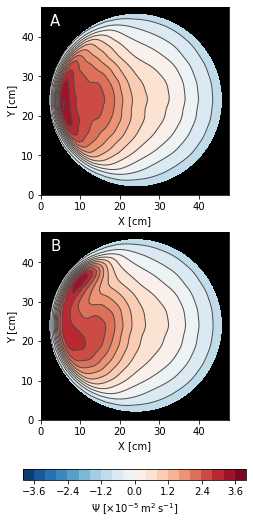

In [123]:
isel=dict(X=slice(0,-1,4),Y=slice(0,-1,4))

vm = 4
dl = 0.4

kw = {
    'contourf': {
        'levels':np.arange(-vm,vm+dl,dl),
        'cmap':'RdBu_r',
    },
    'contour': {
        'levels':np.arange(-vm,vm+dl,dl),
        'linewidths':1,
        'colors':'0.3',
        'linestyles':'solid',
    }
}


fig,ax = plt.subplots(2,1,figsize=(4,10))

ax[0].contourf(X*1e2,Y*1e2,plinear*1e5,**kw['contourf'])
ax[0].contour(X*1e2,Y*1e2,plinear*1e5,**kw['contour'])

# ax[0].quiver(linear.isel(**isel).X*1e2,
#           linear.isel(**isel).Y*1e2,
#           linear.isel(**isel).U.sel(T=ti).mean('Z'),
#           linear.isel(**isel).V.sel(T=ti).mean('Z'),scale=1e-2)

C = ax[1].contourf(X*1e2,Y*1e2,pnlinear*1e5,**kw['contourf'])
ax[1].contour(X*1e2,Y*1e2,pnlinear*1e5,**kw['contour'])

# ax[1].quiver(nlinear.isel(**isel).X*1e2,
#           nlinear.isel(**isel).Y*1e2,
#           nlinear.isel(**isel).U.sel(T=ti).mean('Z'),
#           nlinear.isel(**isel).V.sel(T=ti).mean('Z'),scale=1e-2)

cbar = fig.colorbar(C,ax=ax,orientation='horizontal',pad=0.09)
cbar.set_label('$\Psi$ [$\\times$10$^{-5}$ m$^2\,$s$^{-1}$]')

ax[0].text(0.05,0.9,'A',size=15,color='w',transform=ax[0].transAxes,zorder=1e10)
ax[1].text(0.05,0.9,'B',size=15,color='w',transform=ax[1].transAxes,zorder=1e10)

_ = [a.contourf(x*1e2,y*1e2,rs,[0.22,1],colors='k',zorder=1e6) for a in ax]
_ = [a.axis('scaled') for a in ax]
_ = [a.set(xlabel='X [cm]',ylabel='Y [cm]') for a in ax]

fig.savefig('psi_model.png',dpi=300,bbox_inches='tight')